In [1]:
import tensorflow as tf
import os
from matplotlib import pyplot as plt
import cv2
import numpy as np
import all_operations
from sklearn import tree
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd

In [2]:
model = tf.keras.models.load_model('facenet_weight/facenet_model.h5', compile=False)
print(model.input_shape, model.output_shape)

(None, 160, 160, 3) (None, 128)


In [3]:
faces_path = os.path.join(os.getcwd(), 'Face')
persons = os.listdir(faces_path)
paths = []
samples = []
labels = []
for person in persons:
    person_path = os.path.join(faces_path, person)
    for img_name in os.listdir(person_path):
        img_path = os.path.join(person_path, img_name)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        normalize_img = all_operations.normalize(img)
        paths.append(img_path)
        samples.append(normalize_img)
        labels.append(person)

In [4]:
paths = np.array(paths)
labels = np.array(labels)
np.unique(labels, return_counts=True)

(array(['Adele', 'Cardi B', 'Charlie Cox', 'Cillian Murphy',
        'Elizabeth Olsen', 'Elon Musk', 'Faker', 'Karl Urban',
        'Robert Downey Jr', 'Taylor Swift'], dtype='<U16'),
 array([10,  8,  9,  9, 10,  7,  7,  9,  9,  9], dtype=int64))

In [5]:
samples = np.array(samples)
samples = model.predict(samples)

In [6]:
positives_disc = []
negatives_disc = []

n = samples.shape[0]

for i in range(n-1):
    img1_representation = all_operations.l2_normalize(samples[i])

    for j in range(i+1, n):
        img2_representation = all_operations.l2_normalize(samples[j])
        euclidean_distance = all_operations.findEuclideanDistance(img1_representation, img2_representation)
        
        if labels[i] == labels[j]:
            positives_disc.append(euclidean_distance)
        
        if labels[i] != labels[j]:
            negatives_disc.append(euclidean_distance)

In [7]:
positives_disc = np.array(positives_disc)
negatives_disc = np.array(negatives_disc)

In [8]:
x = np.concatenate([positives_disc, negatives_disc]).reshape(-1, 1)
y = np.concatenate([np.ones(positives_disc.shape[0], 'int'), np.zeros(negatives_disc.shape[0], 'int')])

In [9]:
clf = tree.DecisionTreeClassifier(max_depth=1)
clf = clf.fit(x, y)

[Text(0.5, 0.75, 'X[0] <= 1.049\ngini = 0.165\nsamples = 3741\nvalue = [3401, 340]'),
 Text(0.25, 0.25, 'gini = 0.006\nsamples = 340\nvalue = [1, 339]'),
 Text(0.75, 0.25, 'gini = 0.001\nsamples = 3401\nvalue = [3400, 1]')]

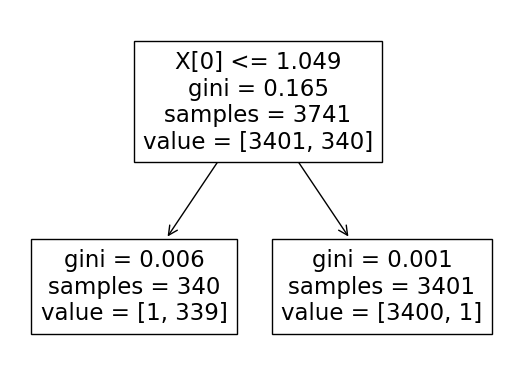

In [10]:
tree.plot_tree(clf)

In [11]:
positives_disc.mean(), positives_disc.max(), positives_disc.min()

(0.6923059, 1.0657761, 0.2701863)

In [12]:
negatives_disc.mean(), negatives_disc.min(), negatives_disc.max()

(1.3907002, 1.0161866, 1.6571186)

In [13]:
df = pd.DataFrame(np.hstack([x, y.reshape(-1, 1)]), columns=['distance', 'match'])
df['match'] = df['match'].astype(int)

<AxesSubplot:ylabel='Density'>

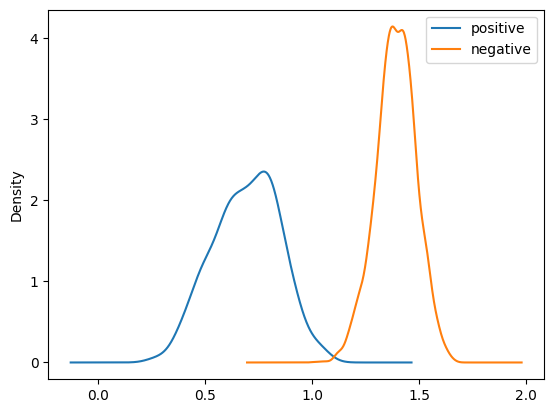

In [14]:
df[df.match == 1].distance.plot.kde(legend = True, label = 'positive')
df[df.match == 0].distance.plot.kde(legend = True, label = 'negative')

In [15]:
threshold = 1.018
df[str(threshold)] = 0
idx = df[df.distance <= threshold].index
df.loc[idx, str(threshold)] = 1

threshold = 1.001
df[str(threshold)] = 0
idx = df[df.distance <= threshold].index
df.loc[idx, str(threshold)] = 1

threshold = 1.122
df[str(threshold)] = 0
idx = df[df.distance <= threshold].index
df.loc[idx, str(threshold)] = 1

In [16]:
def score(threshold):
    return accuracy_score(y, df[str(threshold)]), precision_score(y, df[str(threshold)]), recall_score(y, df[str(threshold)]), f1_score(y, df[str(threshold)])

score(1.018)

(0.9983961507618284,
 0.9970238095238095,
 0.9852941176470589,
 0.9911242603550295)

In [17]:
score(1.001)

(0.9981288425554664, 1.0, 0.9794117647058823, 0.9895988112927191)

In [18]:
score(1.122)

(0.9965249933172948, 0.9631728045325779, 1.0, 0.9812409812409812)